In [97]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import random
from tqdm import tqdm # ladebalken


Konstanten

In [ ]:
ROOT_DIR: str = "data"
IMAGE_SIZE: int = 128
TRAIN_TEST_RATIO: float = 0.2 # Anteil von Test split
BATCH_SIZE: int = 32
HIDDEN_UNITS: int = 32 # anzahl der neuronen im cnn#
LEARNING_RATE: float = 0.01
EPOCHS = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Einheitliche Transformation um Bilder in einem Tensor zu speichern

In [99]:
transform: torchvision.transforms.Compose = torchvision.transforms.Compose([
    # Bilder auf einheitliche Größe bringen
    torchvision.transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    # Bilder in Tensor speichern
    torchvision.transforms.ToTensor()
])

Daten laden

In [100]:
# Daten laden
# Die Klassen werden Automatisch nach den Ordernamen gespeichert
# Daten von www.kaggle.com/datasets/cashbowman/ai-generated-images-vs-real-images
dataset = torchvision.datasets.ImageFolder(root=ROOT_DIR, transform=transform)


Zufällige Bilder darstellen

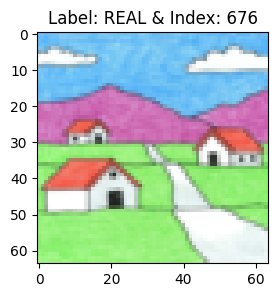

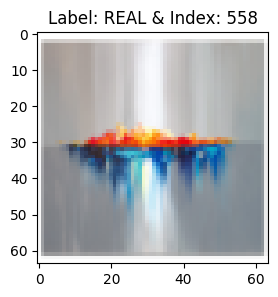

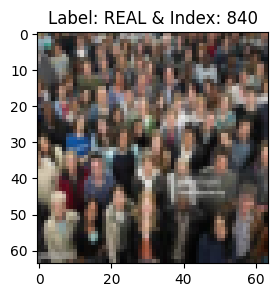

In [101]:
num_images = 3

for _ in range(num_images):

    # Zufälliges Bild und Label speichern
    index = random.randint(0, len(dataset) - 1)
    img, label = dataset[index]

    # Tensor in Bild umwandeln
    img = img.permute(1, 2, 0)

    # Darstelluung mit Pyplot
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.title(f"Label: {dataset.classes[label]} & Index: {index}")

Daten in Trainings und Testdaten speichern

In [102]:
# Train/Test Split berechnen
total_size = len(dataset)
test_size = int(TRAIN_TEST_RATIO * total_size)
train_size = total_size - test_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader mit Batches (z. B. für Training)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# X_train, y_train
X_train = torch.stack([img for img, _ in train_dataset])
y_train = torch.tensor([label for _, label in train_dataset])

# X_test, y_test
X_test = torch.stack([img for img, _ in test_dataset])
y_test = torch.tensor([label for _, label in test_dataset])

c:\Users\Phil\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Ausgabe der Metadaten

In [103]:
print(f"Länge Datensatz: {len(dataset)}\n")
print("Shapes der Tensoren:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}\n")
print(f"Labels: {dataset.classes}")

Länge Datensatz: 973

Shapes der Tensoren:
X_train: torch.Size([779, 3, 64, 64]), y_train: torch.Size([779])
X_test: torch.Size([194, 3, 64, 64]), y_test: torch.Size([194])

Labels: ['AI', 'REAL']


CNN-Model erstellen

In [104]:
class CNNModel(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * (IMAGE_SIZE//4) * (IMAGE_SIZE//4), 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

model = CNNModel(input_shape=3, 
    hidden_units=HIDDEN_UNITS, 
    output_shape=len(dataset.classes)).to(device)

print(model)

CNNModel(
  (block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=2, bias=True)
  )
)


Loss-Function und Optimizer erstellen

In [105]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

Utils

In [106]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [107]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [108]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

Training und Testen

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.69347 | Train accuracy: 50.81%


 33%|███▎      | 1/3 [00:19<00:39, 19.85s/it]

Test loss: 0.68269 | Test accuracy: 54.46%

Epoch: 1
---------
Train loss: 0.68426 | Train accuracy: 55.32%


 67%|██████▋   | 2/3 [00:39<00:19, 19.91s/it]

Test loss: 0.65569 | Test accuracy: 74.55%

Epoch: 2
---------
Train loss: 0.69888 | Train accuracy: 55.18%


100%|██████████| 3/3 [00:59<00:00, 19.90s/it]

Test loss: 0.68707 | Test accuracy: 54.46%



In [110]:
# Get model results 
model_results = eval_model(
    model=model,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_results

{'model_name': 'CNNModel',
 'model_loss': 0.687073290348053,
 'model_acc': 54.464285714285715}